In [740]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

In [741]:
# DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# print(f"using PyTorch version: {torch.__version__}, Device: {DEVICE}")

In [742]:
data, info = tfds.load('horses_or_humans', with_info=True)
print(data.keys())

dict_keys(['train', 'test'])


In [743]:
ds_train = data['train']
print(len(ds_train), type(ds_train))

ds_train = ds_train.map(lambda x:( x['image'], x['label']))
ds_train = ds_train.shuffle(200).batch(1027)
train_batch = next(iter(ds_train))
print(train_batch[0].shape, type(train_batch[0]), train_batch[1].shape, type(train_batch))

x_train, y_train = train_batch

print(x_train.shape, type(x_train), y_train.shape, type(y_train))


1027 <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
(1027, 300, 300, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> (1027,) <class 'tuple'>
(1027, 300, 300, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> (1027,) <class 'tensorflow.python.framework.ops.EagerTensor'>


In [744]:
ds_test = data['test']
print(len(ds_test), type(ds_test))

ds_test = ds_test.map(lambda x:((x['image'], x['label'])))
ds_test = ds_test.shuffle(50).batch(256)
test_batch = next(iter(ds_test))
print(test_batch[0].shape, type(test_batch[1]), test_batch[1].shape, type(test_batch[1]))

x_test, y_test = test_batch

print(x_test.shape, type(x_test), y_test.shape, type(y_test))


256 <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
(256, 300, 300, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> (256,) <class 'tensorflow.python.framework.ops.EagerTensor'>
(256, 300, 300, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> (256,) <class 'tensorflow.python.framework.ops.EagerTensor'>


In [745]:
# 그림을 그리기 위해서...

images = np.array(x_train) / 255
labels = np.array(y_train)

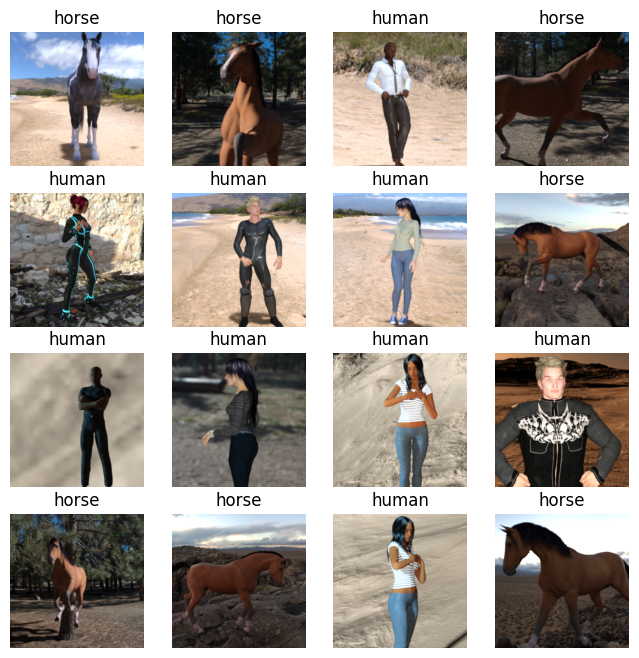

In [746]:
import matplotlib.pyplot as plt
import random

label_map = { 0 : 'horse', 1 : 'human'}

plt.figure(figsize=(8, 8))
random_idx = np.random.randint(0, x_train.shape[0], size=16)
for i, idx in enumerate(random_idx) :
    img = images[idx]
    label_idx = labels[idx]
    label = label_map[label_idx]
    plt.subplot(4, 4, i+1)
    plt.imshow(img, 'gray')
    plt.title(label)
    plt.axis('off')
plt.show()

In [747]:
import torch

# TensorFlow의 EagerTensor를 NumPy 배열로 변환한 후에 torch.Tensor로 변환
x_train = torch.tensor(x_train.numpy())
y_train = torch.tensor(y_train.numpy())
print(x_train.shape, type(x_train))


# TensorFlow의 EagerTensor를 NumPy 배열로 변환한 후에 torch.Tensor로 변환
x_test = torch.tensor(x_test.numpy())
y_test = torch.tensor(y_test.numpy())
print(x_test.shape, type(x_test))

torch.Size([1027, 300, 300, 3]) <class 'torch.Tensor'>
torch.Size([256, 300, 300, 3]) <class 'torch.Tensor'>


In [748]:
x_train = x_train.permute(0, 3, 1, 2)
x_test = x_test.permute(0, 3, 1, 2)
print(x_train.shape)
print(x_test.shape)

torch.Size([1027, 3, 300, 300])
torch.Size([256, 3, 300, 300])


In [749]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)

# 데이터로더 생성
batch_size = 64

# Create data loaders.
train_dataset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for X, y in test_dataset_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
# 이제 train_loader를 사용하여 모델을 훈련하시면 됩니다!



Shape of X [N, C, H, W]: torch.Size([64, 3, 300, 300])
Shape of y: torch.Size([64]) torch.int64


In [750]:
images, labels = next(iter(train_dataset_loader))

print(images.shape, type(images))

torch.Size([64, 3, 300, 300]) <class 'torch.Tensor'>


In [751]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*300*300, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=270000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)


In [752]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=2e-6)

In [753]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device).float(), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 3 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [754]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device).float(), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [755]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataset_loader, model, loss_fn, optimizer)
    test(test_dataset_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.270557  [   64/ 1027]
loss: 12.417480  [  256/ 1027]
loss: 9.616403  [  448/ 1027]
loss: 4.209847  [  640/ 1027]
loss: 0.977268  [  832/ 1027]
loss: 4.193021  [ 1024/ 1027]
Test Error: 
 Accuracy: 51.2%, Avg loss: 8.372499 

Epoch 2
-------------------------------
loss: 2.993520  [   64/ 1027]
loss: 1.250587  [  256/ 1027]
loss: 3.214621  [  448/ 1027]
loss: 0.849942  [  640/ 1027]
loss: 0.878731  [  832/ 1027]
loss: 0.418965  [ 1024/ 1027]
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.585893 

Epoch 3
-------------------------------
loss: 0.233991  [   64/ 1027]
loss: 0.194646  [  256/ 1027]
loss: 0.407150  [  448/ 1027]
loss: 0.283152  [  640/ 1027]
loss: 0.421704  [  832/ 1027]
loss: 0.233779  [ 1024/ 1027]
Test Error: 
 Accuracy: 58.6%, Avg loss: 2.211875 

Epoch 4
-------------------------------
loss: 2.111513  [   64/ 1027]
loss: 2.101103  [  256/ 1027]
loss: 0.412967  [  448/ 1027]
loss: 1.222500  [  640/ 1027]
loss: 0.237131  [  832/

In [756]:
# def train(dataloader, model, loss_fn, optimizer):
#     size = len(dataloader.dataset)
#     model.train()

#     for images, labels in train_dataset_loader:
#         x_train = images.to(device).float()
#         y_train = labels.to(device)

#         # Compute prediction error
#         pred = model(x_train)
#         loss = loss_fn(pred, y_train)

#         # Backpropagation
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         # if batch % 100 == 0:
#         #     loss, current = loss.item(), (batch + 1) * len(x_train)
#         # print(f"loss: {loss:>7f}")




def model_train(dataloader, model, loss_function, optimizer):

    model.train()

    train_loss_sum = train_correct = train_total = 0

    total_train_batch = len(dataloader)

    for images, labels in dataloader:

        x_train = images.to(device).float()
        y_train = labels.to(device)

        outputs = model(x_train)
        loss = loss_function(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()

        train_total += y_train.size(0)
        train_correct += ((torch.argmax(outputs, 1)==y_train)).sum().item()

    train_avg_loss = train_loss_sum / total_train_batch
    train_avg_accuracy = 100*train_correct / train_total

    return (train_avg_loss, train_avg_accuracy)

In [757]:
# def test(dataloader, model, loss_fn):
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     model.eval()
#     test_loss, correct = 0, 0
#     with torch.no_grad():
#         for X, y in test_dataset_loader:
#             x_test = X.to(device).float()
#             y_test = y.to(device)
            
#             pred = model(x_test)
#             test_loss += loss_fn(pred, y_test).item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()
#     test_loss /= num_batches
#     correct /= size
#     # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


def model_evaluate(dataloader, model, loss_function, optimizer):

    model.eval()

    with torch.no_grad():

        val_loss_sum = val_correct = val_total = 0

        total_val_batch = len(dataloader)

        for images, labels in dataloader:

            x_val = images.to(device).float()
            y_val = labels.to(device)

            outputs = model(x_val)
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()

            val_total += y_val.size(0)
            val_correct += ((torch.argmax(outputs, 1)==y_val)).sum().item()

        val_avg_loss = val_loss_sum / total_val_batch
        val_avg_accuracy = 100*val_correct / val_total

    return (val_avg_loss, val_avg_accuracy)

In [758]:
# from datetime import datetime


# epochs = 30
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
# #     train(train_dataset_loader, model, loss_fn, optimizer)
# #     test(test_dataset_loader, model, loss_fn)
# # print("Done!")


#     print('epoch:', '%02d' % (epochs + 1),
#           'train loss =', '{:.3f}'.format(train_avg_loss), 'train acc =', '{:.3f}'.format(train_avg_accuracy),
#           'val loss =', '{:.3f}'.format(val_avg_loss), 'val acc =', '{:.3f}'.format(val_avg_accuracy))

In [759]:
from datetime import datetime

train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()
EPOCHS = 100

for epoch in range(EPOCHS):

    #==============  model train  ================
    train_avg_loss, train_avg_accuracy = model_train(train_dataset_loader, model, loss_fn, optimizer)

    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)
    #=============================================

    #============  model evaluation  ==============
    val_avg_loss, val_avg_accuracy = model_evaluate(test_dataset_loader, model, loss_fn, optimizer)

    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)
    #============  model evaluation  ==============

    print('epoch:', '%02d' % (epoch + 1),
          'train loss =', '{:.3f}'.format(train_avg_loss), 'train acc =', '{:.3f}'.format(train_avg_accuracy),
          'val loss =', '{:.3f}'.format(val_avg_loss), 'val acc =', '{:.3f}'.format(val_avg_accuracy))

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)

epoch: 01 train loss = 0.135 train acc = 94.645 val loss = 0.520 val acc = 82.031
epoch: 02 train loss = 0.305 train acc = 87.731 val loss = 0.616 val acc = 85.938
epoch: 03 train loss = 0.107 train acc = 96.592 val loss = 0.415 val acc = 89.844
epoch: 04 train loss = 0.101 train acc = 96.397 val loss = 0.435 val acc = 89.453
epoch: 05 train loss = 0.070 train acc = 97.955 val loss = 0.883 val acc = 81.250
epoch: 06 train loss = 0.060 train acc = 98.637 val loss = 0.751 val acc = 83.984
epoch: 07 train loss = 0.085 train acc = 96.981 val loss = 2.092 val acc = 67.188
epoch: 08 train loss = 0.087 train acc = 96.981 val loss = 0.900 val acc = 81.250
epoch: 09 train loss = 0.054 train acc = 98.832 val loss = 0.613 val acc = 86.719
epoch: 10 train loss = 0.041 train acc = 99.611 val loss = 0.946 val acc = 81.250
epoch: 11 train loss = 0.044 train acc = 99.708 val loss = 2.668 val acc = 62.500
epoch: 12 train loss = 0.135 train acc = 94.547 val loss = 0.968 val acc = 80.859
epoch: 13 train 

In [760]:
def model_test(dataloader, model):

    model.eval()

    with torch.no_grad():

        test_loss_sum = 0
        test_correct=0
        test_total = 0

        total_test_batch = len(dataloader)

        for images, labels in dataloader:

            x_test = images.to(device).float()
            y_test = labels.to(device)

            outputs = model(x_test)
            loss = loss_fn(outputs, y_test)

            test_loss_sum += loss.item()

            test_total += y_test.size(0)
            test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item()

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100*test_correct / test_total

        print('accuracy:', test_avg_accuracy)
        print('loss:', test_avg_loss)

In [761]:
# test dataset 으로 정확도 및 오차 테스트

model_test(test_dataset_loader, model)


accuracy: 85.15625
loss: 0.7969467341899872


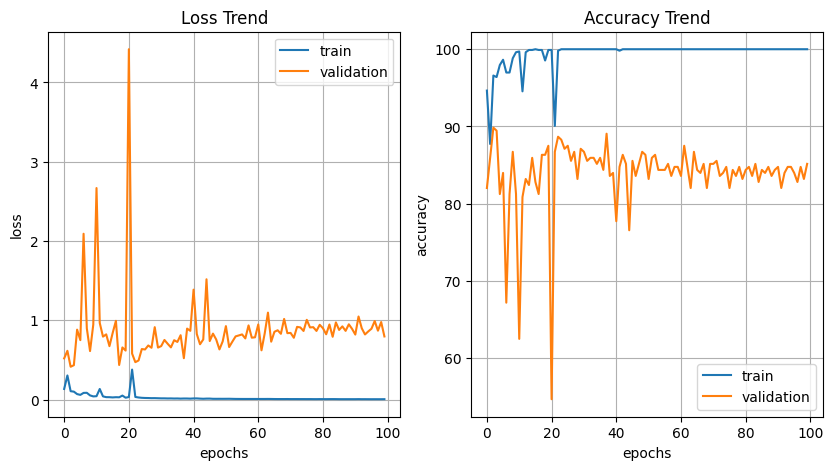

In [762]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.plot(train_accuracy_list, label='train')
plt.plot(val_accuracy_list, label='validation')
plt.legend()

plt.show()

In [763]:
def imshow(image) :
  image = image /2 + 0.5
  npimg = image.numpy()

  fig = plt.figure(figsize=(16, 8))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

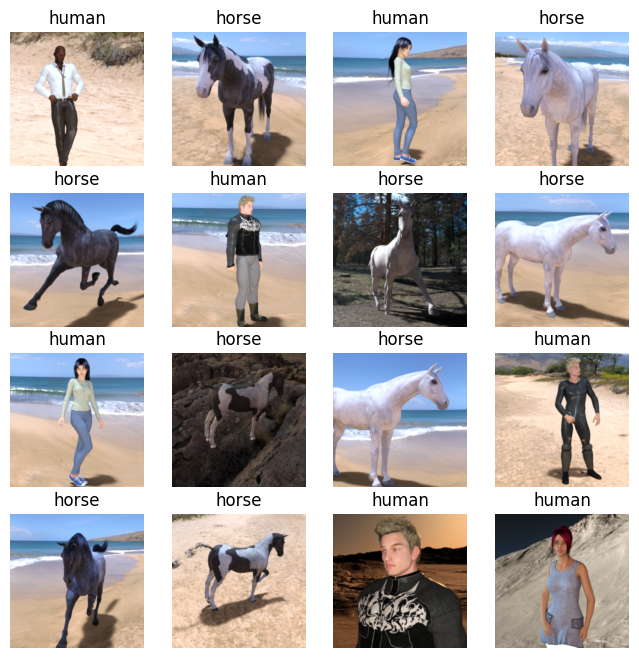

In [764]:
plt.figure(figsize=(8, 8))
rows, cols = 4, 4
for i in range(16) :
  img = images[i].permute(1, 2, 0)
  label_idx = labels[i].item()
  label = label_map[label_idx]
  plt.subplot(rows, cols, i+1)
  plt.imshow(img, 'gray')
  plt.title(label)
  plt.axis('off')
plt.show()

In [765]:
class MyCNNModel(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(1*1*256, 128)
        self.fc2 = nn.Linear(128, 2)

        self.dropout25 = nn.Dropout(p=0.25)
        self.dropout50 = nn.Dropout(p=0.5)

    def forward(self, data):

        data = self.conv1(data)
        data = torch.relu(data)
        data = self.conv2(data)
        data = torch.relu(data)
        data = self.pooling(data)
        data = self.dropout25(data)

        data = self.conv3(data)
        data = torch.relu(data)
        data = self.conv4(data)
        data = torch.relu(data)
        data = self.pooling(data)
        data = self.dropout25(data)

        data = self.conv5(data)
        data = torch.relu(data)
        data = self.pooling(data)
        data = self.dropout25(data)

        data = self.conv6(data)
        data = torch.relu(data)
        data = self.pooling(data)
        data = self.dropout25(data)

        data = self.conv7(data)
        data = torch.relu(data)
        data = self.pooling(data)
        data = self.dropout25(data)

        data = data.view(-1, 1 * 1 * 256)

        data = self.fc1(data)
        data = torch.relu(data)
        data = self.dropout50(data)

        logits = self.fc2(data)

        return logits

net=MyCNNModel()
print(net)

MyCNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (dropout25): Dropout(p=0.25, inplace=False)
  (dropout50): Dropout(p=0.5, inplace=False)
)


In [766]:
model = MyCNNModel().to(DEVICE)

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [767]:
def model_train(dataloader, model, loss_function, optimizer):

    model.train()

    train_loss_sum = train_correct = train_total = 0

    total_train_batch = len(dataloader)

    for images, labels in dataloader:

        x_train = images.to(DEVICE).float()
        y_train = labels.to(DEVICE)

        outputs = model(x_train)
        loss = loss_function(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()

        train_total += y_train.size(0)
        train_correct += ((torch.argmax(outputs, 1)==y_train)).sum().item()

    train_avg_loss = train_loss_sum / total_train_batch
    train_avg_accuracy = 100*train_correct / train_total

    return (train_avg_loss, train_avg_accuracy)

In [768]:
def model_evaluate(dataloader, model, loss_function, optimizer):

    model.eval()

    with torch.no_grad():

        val_loss_sum = val_correct = val_total = 0

        total_val_batch = len(dataloader)

        for images, labels in dataloader:

            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            outputs = model(x_val)
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()

            val_total += y_val.size(0)
            val_correct += ((torch.argmax(outputs, 1)==y_val)).sum().item()

        val_avg_loss = val_loss_sum / total_val_batch
        val_avg_accuracy = 100*val_correct / val_total

    return (val_avg_loss, val_avg_accuracy)

In [769]:
from datetime import datetime

train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()
EPOCHS = 100

for epoch in range(EPOCHS):

    #==============  model train  ================
    train_avg_loss, train_avg_accuracy = model_train(train_dataset_loader, model, loss_function, optimizer)

    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)
    #=============================================

    #============  model evaluation  ==============
    val_avg_loss, val_avg_accuracy = model_evaluate(test_dataset_loader, model, loss_function, optimizer)

    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)
    #============  model evaluation  ==============

    print('epoch:', '%02d' % (epoch + 1),
          'train loss =', '{:.3f}'.format(train_avg_loss), 'train acc =', '{:.3f}'.format(train_avg_accuracy),
          'val loss =', '{:.3f}'.format(val_avg_loss), 'val acc =', '{:.3f}'.format(val_avg_accuracy))

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)

ValueError: Expected input batch_size (5184) to match target batch_size (64).

In [ ]:
def model_test(dataloader, model):

    model.eval()

    with torch.no_grad():

        test_loss_sum = 0
        test_correct=0
        test_total = 0

        total_test_batch = len(dataloader)

        for images, labels in dataloader:

            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            outputs = model(x_test)
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()

            test_total += y_test.size(0)
            test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item()

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100*test_correct / test_total

        print('accuracy:', test_avg_accuracy)
        print('loss:', test_avg_loss)

In [ ]:
# test dataset 으로 정확도 및 오차 테스트

model_test(test_dataset_loader, model)

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.plot(train_accuracy_list, label='train')
plt.plot(val_accuracy_list, label='validation')
plt.legend()

plt.show()